## Methods and Results
Data are collected from two thermistor chains in the Santa Barbara Channel. The chains are separated by 2 km. The record contains about 10 days worth of temperature data recorded at 46 depths and sampled every minute. The internal wave field moves isopycnal layers up and down within the ocean. The thermistor readings are held fixed by the mooring and are therefore subjected to temperature changes caused by the internal wave field. Figure 1 shows the depth average temperature variation. The data appear to be in phase with each other throughout the record especially at the M2 frequency.

                 depth       temp
time                             
1473369000  158.944978  10.689609
1473369060  158.944978  10.687935
1473369120  158.944978  10.680630
1473369180  158.944978  10.670152
1473369240  158.944978  10.669717
...                ...        ...
1474234800  158.944978  10.817696
1474234860  158.944978  10.823000
1474234920  158.944978  10.829196
1474234980  158.944978  10.833826
1474235040  158.944978  10.837978

[14435 rows x 2 columns]


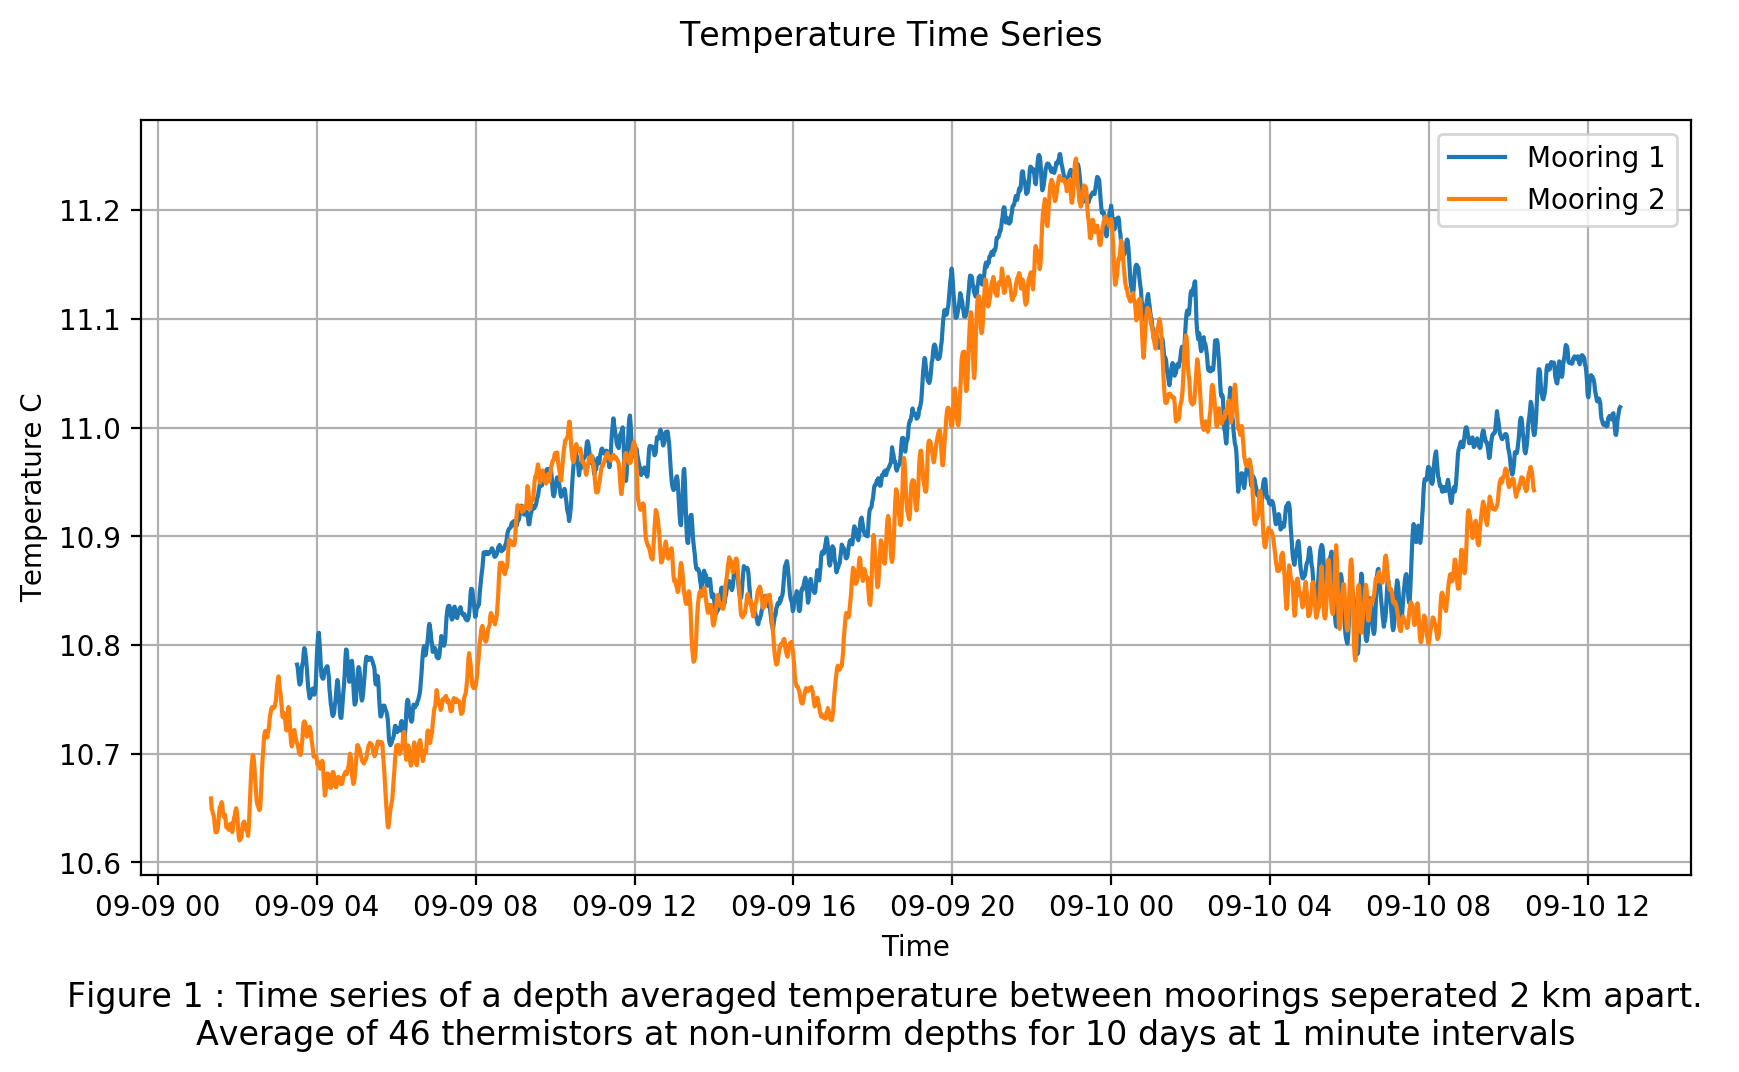

In [75]:
import scipy.io as scio
import pandas as pd 
import xarray as xr
import datetime as dt
import utils
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib import rc
import scipy.signal as signal
import plotly

def convert_to_ts(seconds):
    dt_list = []
    for s in np.nditer(seconds):
        dt_list.append(datetime.fromtimestamp(s))
    return dt_list


def load_dataframe(path):
    keys = ['time','depth','temp']
    mat  = scio.loadmat(path)
    return pd.DataFrame(dict((k, mat[k].flatten()) for k in keys))

#Thermistor chain at 34.2545, -120.0974
TS1 = load_dataframe('../matlab/TS_1.mat')

#Thermistor chain at 34.2389, -120.1026
TS2 = load_dataframe('../matlab/TS_2.mat')

#Depth Average
depths1 = np.unique(TS1.depth)
depths2 = np.unique(TS2.depth)
#TS1_DA = TS1.loc[TS1.depth==depths1[25]] #TS1.groupby('time').mean()
#TS2_DA = TS2.loc[TS2.depth==depths2[25]] #TS2.groupby('time').mean()
TS1_DA = TS1.groupby('time').mean()
TS2_DA = TS2.groupby('time').mean()

print(TS1_DA)
s1 = slice(800,2800)
s2 = slice(500,2500)
f,ax = plt.subplots()
ax.plot(convert_to_ts(TS1_DA.index[s1]),TS1_DA.temp[s1],label='Mooring 1')
ax.plot(convert_to_ts(TS2_DA.index[s2]),TS2_DA.temp[s2],label='Mooring 2')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Temperature C')
f.suptitle('Temperature Time Series')
f.set_size_inches(10,5)
f.set_dpi(200)
ax.legend(loc='upper right')

txt = """ Figure 1 : Time series of a depth averaged temperature between moorings seperated 2 km apart. 
        Average of 46 thermistors at non-uniform depths for 10 days at 1 minute intervals """


foo = plt.figtext(0.5, -0.04, txt, wrap=True, horizontalalignment='center', fontsize=12)

In [88]:
import plotly.io as pio
pio.renderers.default = "browser"
import plotly.graph_objects as go
fig = go.Figure([go.Scatter(x=convert_to_ts(TS1_DA.index),y=TS1_DA.temp),
                 go.Scatter(x=convert_to_ts(TS2_DA.index),y=TS2_DA.temp)])
fig.show()

Assuming the internal wave field is dominating the temperature changes on these scales we would like to elucidate the power spectra of the internal wave field. A Welch method is used to estimate the power spectrum of each mooring. A 10 day record is too short to properly resolve the entire internal wave frequency spectrum which can span from the inertial frequency ( cycle per day ) to the buoyancy frequency (several cycles per hour).



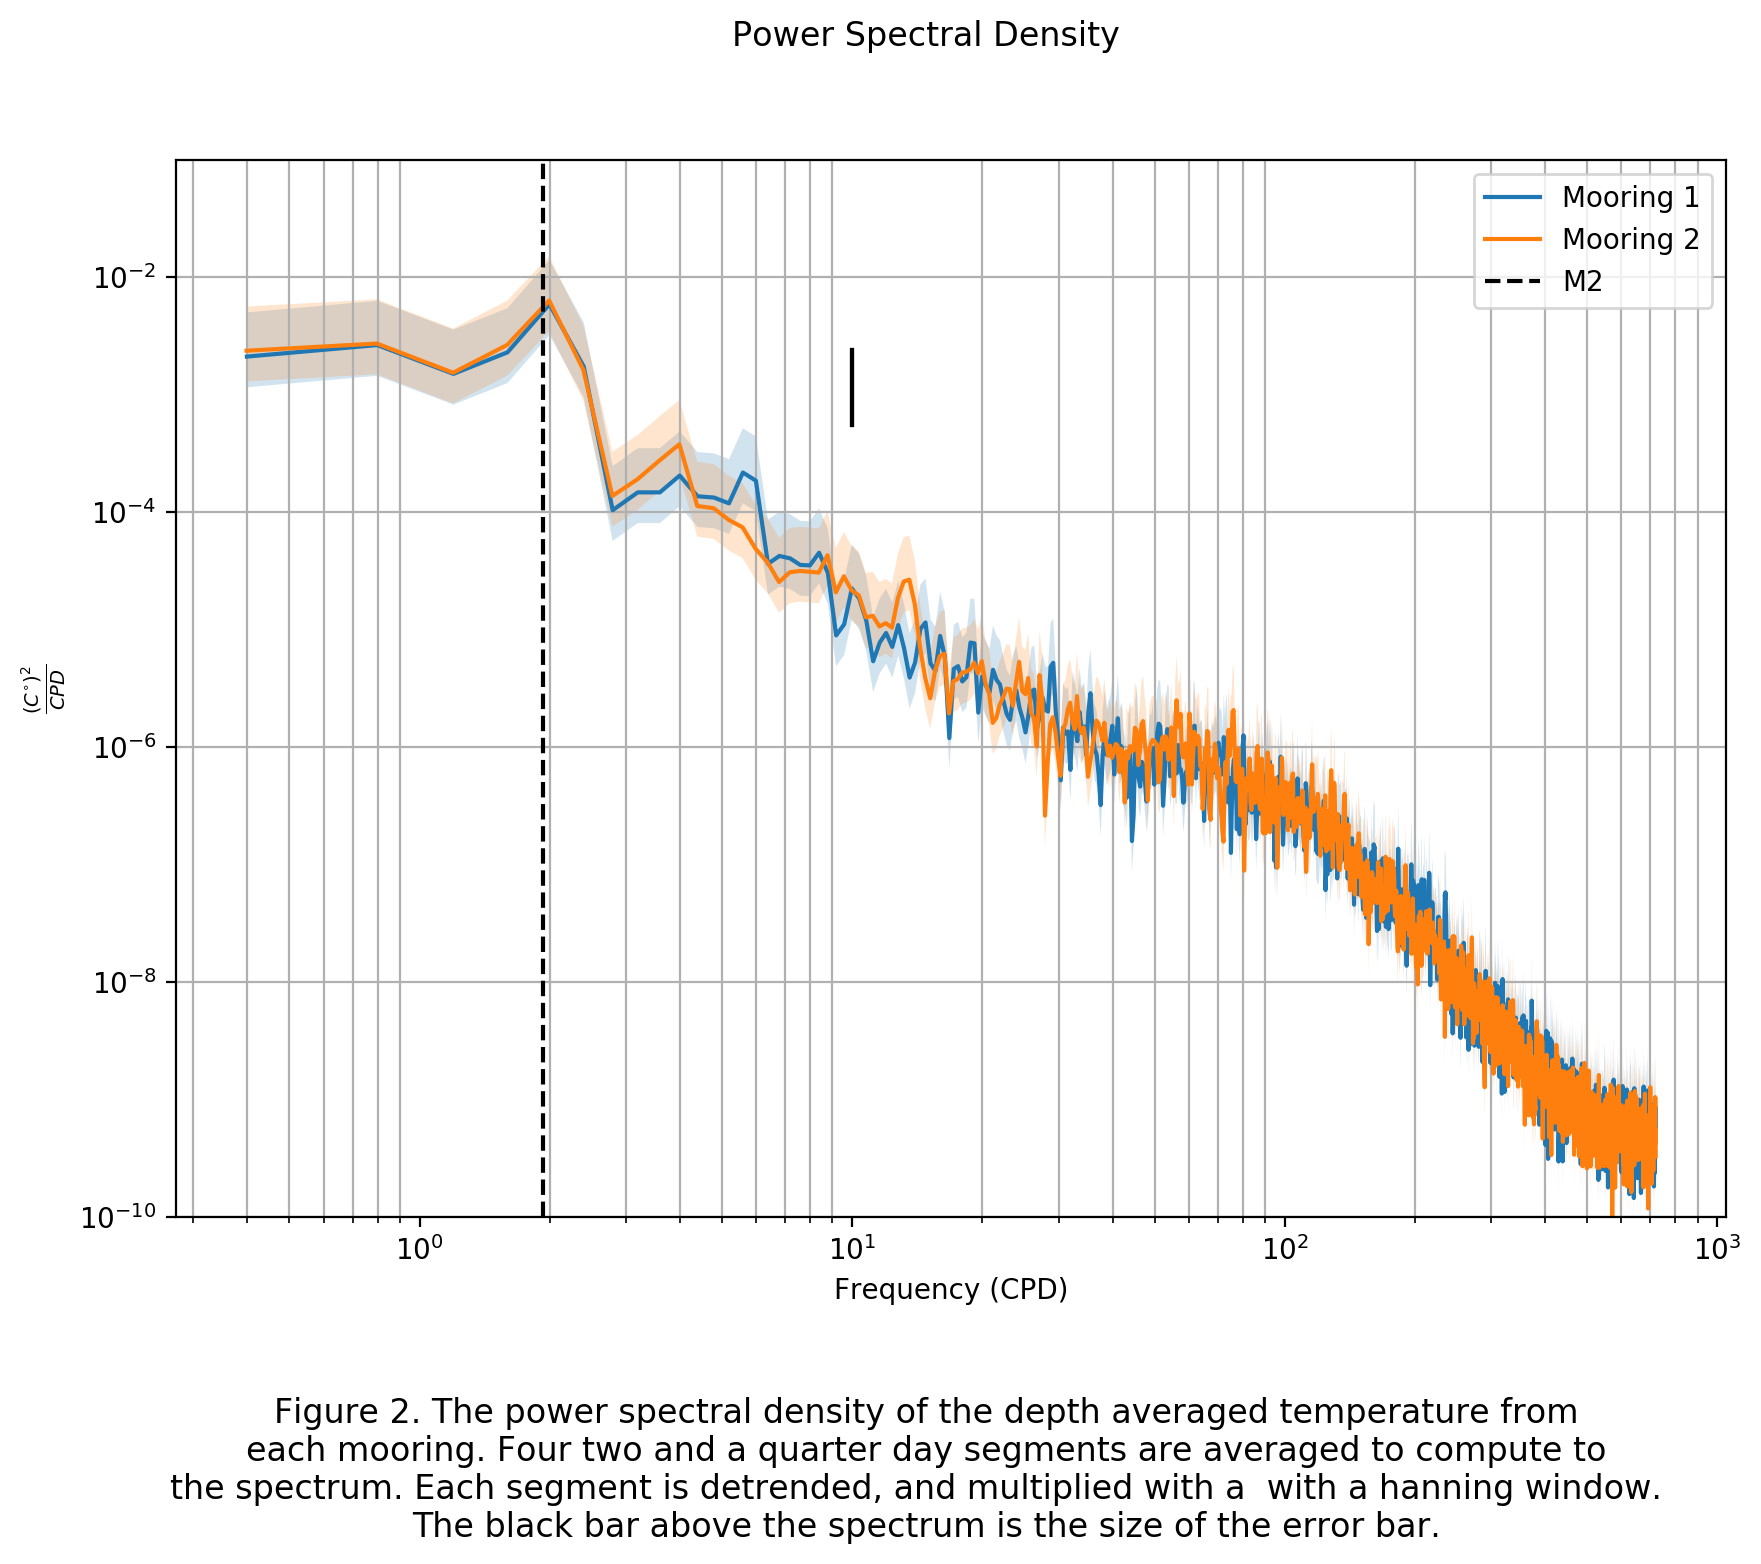

In [59]:

FS = 60*24 #Sampled per minute meaning 24*60 samples per day
M  = 4      #Number of segments

def plot_psd_(ax,D,M,FS,label):
    freqs,psd   = utils.psd(D,M=M,FS=FS)
    high,low    = utils.psd_err(M) #Specific for welch with hanning
    ax.loglog(freqs,psd,label=label)
    ax.fill_between(freqs,psd*low,psd*high,alpha=0.2)
    ax.plot(np.ones(10)*1e1,np.linspace(1e-3*low,1e-3*high,10),color='black')
    

f,ax = plt.subplots()
plot_psd_(ax,TS1_DA.temp,M,FS,'Mooring 1')
plot_psd_(ax,TS2_DA.temp,M,FS,'Mooring 2')
ax.plot( np.ones(50)*(0.0805*24),np.linspace(1e-10,1e-1),'k--',label='M2')
ax.xaxis.grid(True, which='minor')
ax.yaxis.grid()
ax.set_xlabel('Frequency (CPD)')
ax.set_ylabel(r'$\frac{(C^{\circ})^2}{CPD}$')
ax.set_ylim(1e-10,1e-1)
f.suptitle('Power Spectral Density')
ax.legend()
f.set_size_inches(10,7)
f.set_dpi(200)

txt = """Figure 2. The power spectral density of the depth averaged temperature from
each mooring. Four two and a quarter day segments are averaged to compute to
the spectrum. Each segment is detrended, and multiplied with a  with a hanning window.  
The black bar above the spectrum is the size of the error bar."""

foo = plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)

The internal wave spectrum, displayed in Figure 2, is predictably red and there is a clear peak at the M2 tidal frequency. The broadness of the peak can be attributed to the lack of frequency resolution. The resolution is not good enough to resolve M2 precisely and therefore neighboring frequencies around M2 are also given energy. There is a drop off in energy at around 100 cycles per day, indicating a cut off in energy above the buoyancy frequency. The power spectra of the mooring are similar,however we will need to analyze the cross spectrum to tell if there are coherent frequencies. The cross spectrum $S_{xy}$ represents the spectral energy that is correlated between the signals. The square coherence is the cross spectrum is normalized over the power spectrum of each signal. The square coherence is computed between the two moorings as follows
$$ \gamma^2  = \frac{S_{xy}^2}{P_{xx} P_{yy}} $$

The coherence is normalized to one and represents the the phase consistency between the two signals. The coherence of the data can be compared to the expected coherence of white noise. The significance limit, $\beta$, is the level of coherence that encapsulates a certain percentage of the noise. It is defined below. The significance limit is a bench mark that distinguishes our measurement of coherence from the coherence of a random signal.

$$ \beta = 1 - \alpha^{\frac{1}{n_d-1}} $$



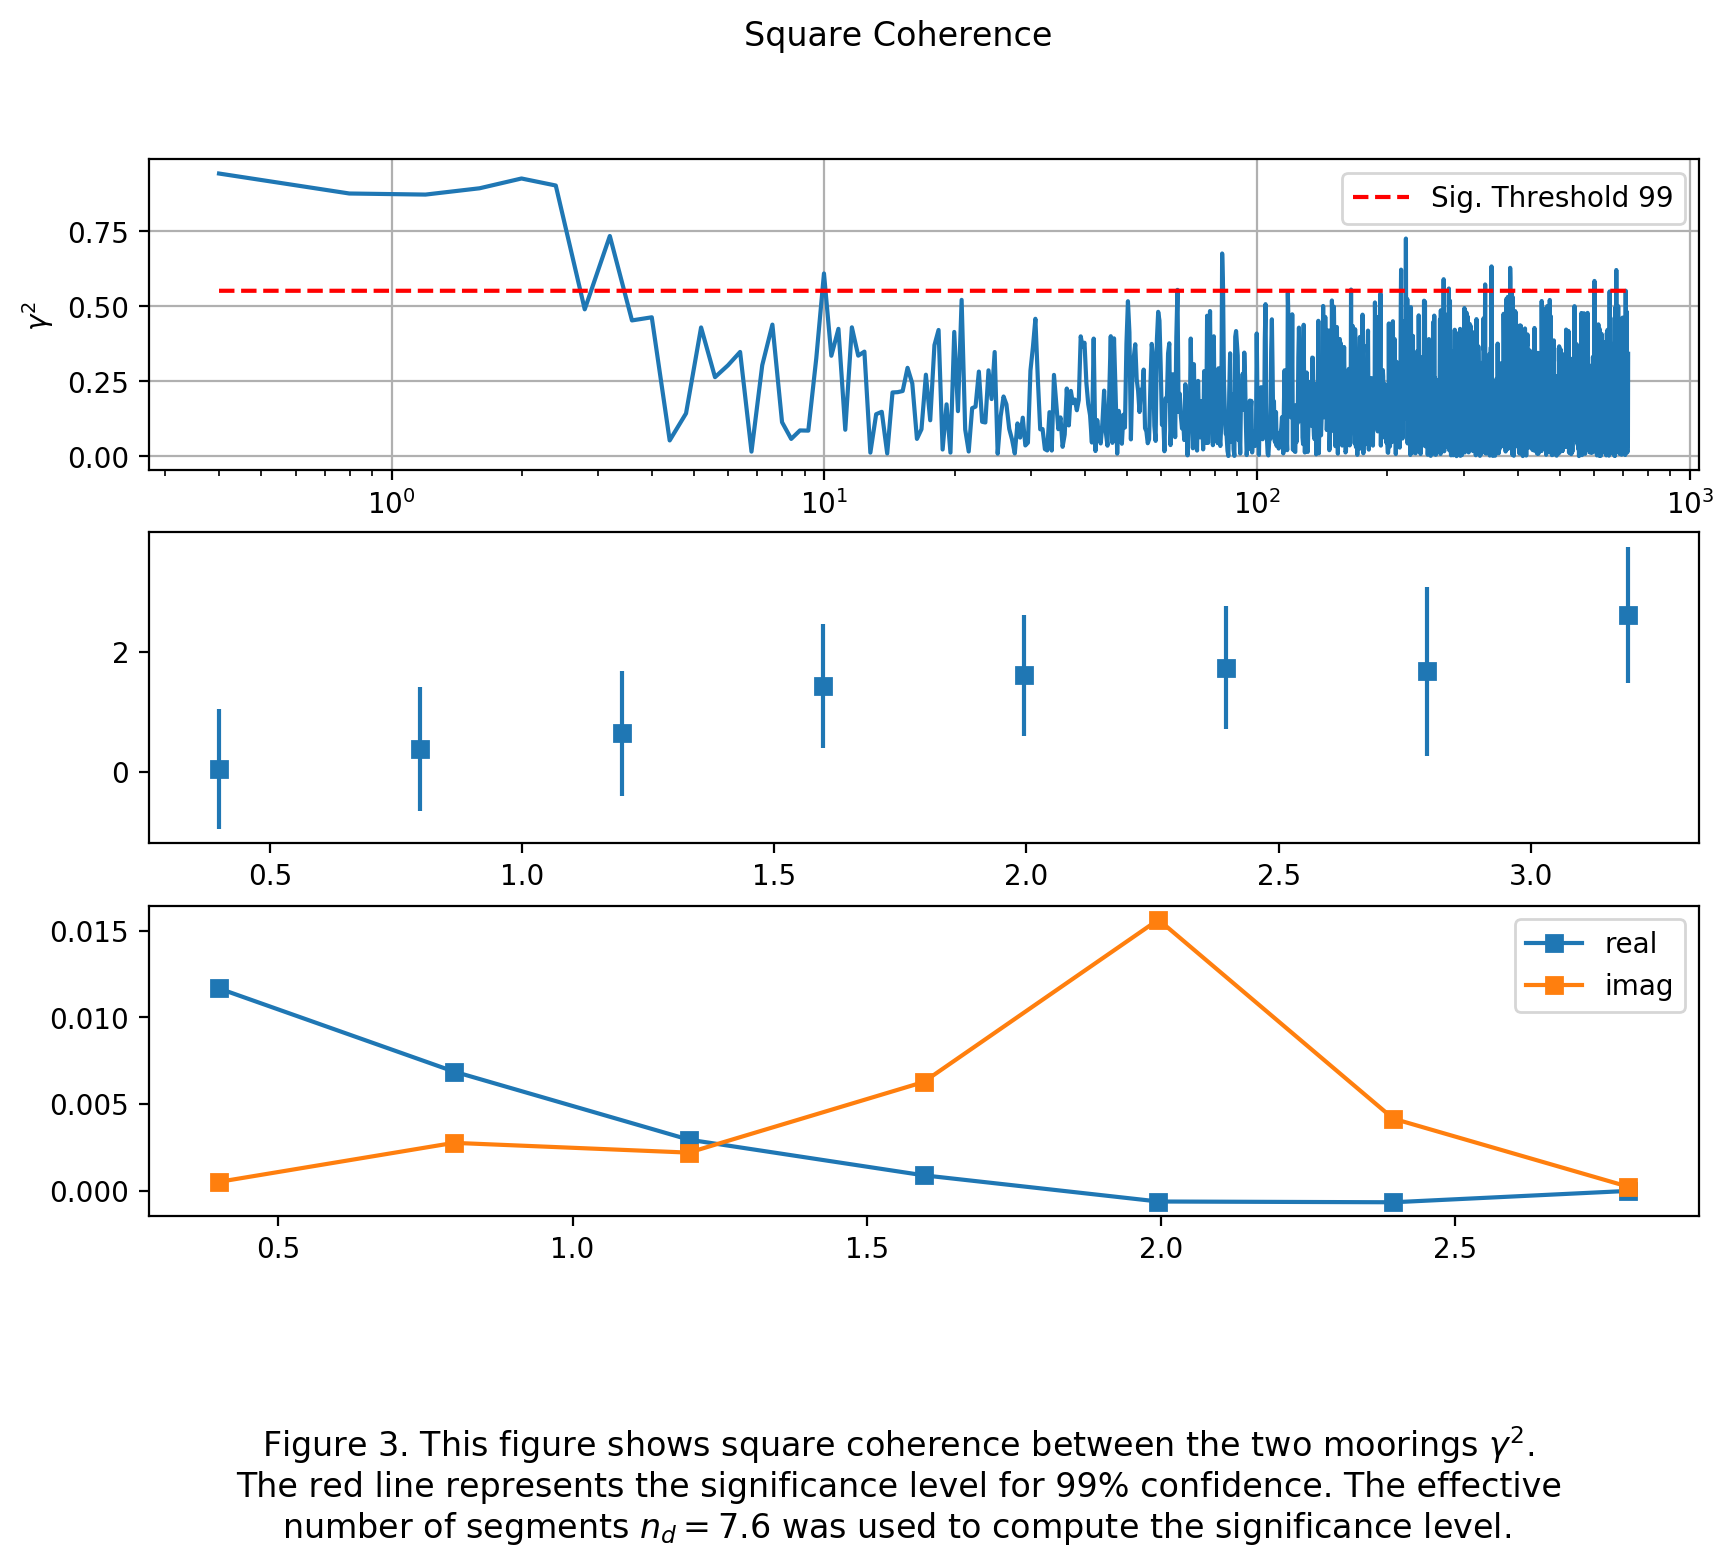

In [63]:
def plot_coh(ax,D1,D2,M,FS,label):
    nperseg = int(len(D1)/M)
    freqs,coh = signal.coherence(D1,D2,nperseg=nperseg,fs=FS)
    ax.semilogx(freqs[1:],coh[1:])
    return freqs[1:],coh[1:]

def plot_csd(ax,D1,D2,M,FS,label,si):
    nperseg = int(len(D1)/M)
    freqs, Pxy = signal.csd(D1,D2, nperseg=nperseg,fs=FS)
    ax.plot(freqs[si],Pxy.real[si],marker='s',label='real')
    ax.plot(freqs[si],Pxy.imag[si],marker='s',label='imag')

def plot_phase(ax,D1,D2,M,FS,label,si):
    nperseg = int(len(D1)/M)
    freqs, Pxy = signal.csd(D1,D2, nperseg=nperseg,fs=FS)
    freqs,coh = signal.coherence(D1,D2,nperseg=nperseg,fs=FS)
    freqs = freqs[1:]
    coh = coh[1:]
    #phase = np.arctan2(-Pxy.imag[1:] , Pxy.real[1:])
    phase = np.angle(Pxy[1:])
    
    err = np.sqrt(1-coh[si]/(2*nd))/(np.sqrt(coh[si]))
    ax.errorbar(freqs[si],phase[si],yerr=err,marker='s',ls='none')
    #ax.errorbar(freqs[si],phase[si],marker='s',ls='none')
    return freqs[si],phase[si],err

f,ax = plt.subplots(3,1)
freqs,coh = plot_coh(ax[0],TS1_DA.temp,TS2_DA.temp,M,FS,'Sq. Coh')
plot_phase(ax[1],TS1_DA.temp,TS2_DA.temp,M,FS,'phase',np.arange(0,8))
plot_csd(ax[2],TS1_DA.temp,TS2_DA.temp,M,FS,'csd',np.arange(1,8))

#Significance Theshold
nd = 2*M*0.95
beta = 1 - (0.005)**(1/(nd-1))
ax[0].plot(freqs,beta*np.ones(len(freqs)),'r--',label='Sig. Threshold 99')
ax[0].grid()
ax[0].set_xlabel('Frequency (CPD)')
ax[0].set_ylabel(r'$\gamma^2$')
f.suptitle('Square Coherence')
l = ax[0].legend()
l = ax[2].legend()
f.set_size_inches(10,7)
f.set_dpi(200)

txt = r"""Figure 3. This figure shows square coherence between the two moorings $\gamma^2$.
          The red line represents the significance level for 99% confidence. The effective
          number of segments $n_d = 7.6$ was used to compute the significance level. """

foo = plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)


 Figure 3 shows several frequencies above the significance level. The M2 peak is notably maximal coherence. The frequency resolution is around 0.018 cycles per hour explaining the broadness around the peak. More data is needed to distinguish M2 from its neighboring frequencies. The coherence sharply drops after the M2 because these waves are generally caused by the  scattering of the internal wave making them less coherent. However, there are frequencies above the M2 that are coherent seen in Figure 3. Though frequencies above 100 cycles per day are most likely not significant because of the physical cutoff $f \lt \omega \lt N(z)$ derived from the internal wave dispersion.

[ 21.83830264  36.67300257  82.01219459  92.32227599  99.2848172
 149.69163848  99.58809909  39.60735613 -10.67533146]
[0.03325942 0.04988914 0.06651885 0.08314856 0.09977827 0.13303769
 0.41574279 2.72727273 3.45898004]


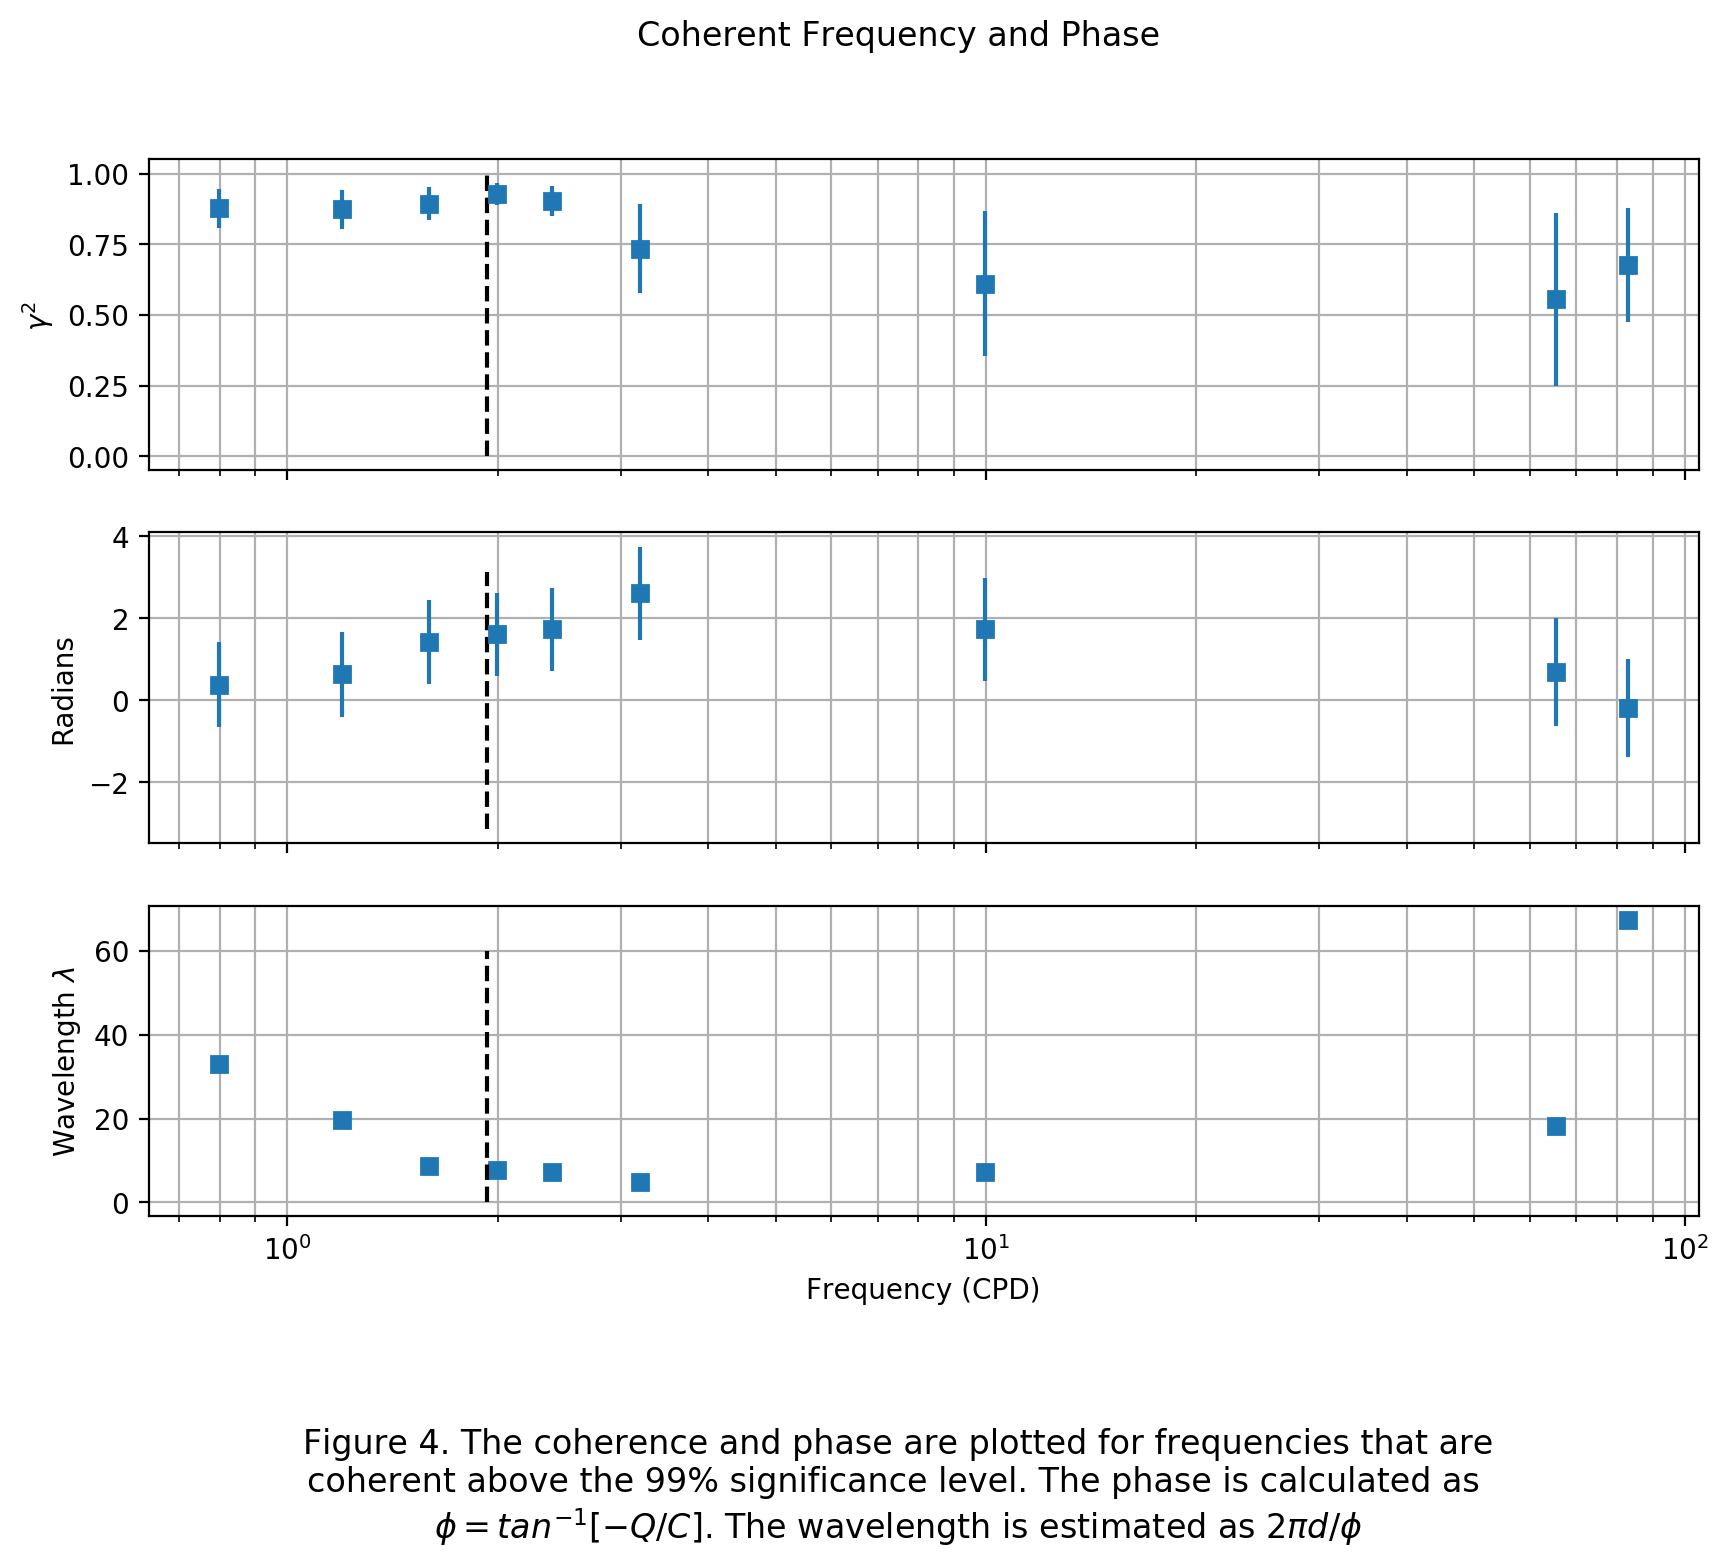

In [64]:
sig_ind = np.where(coh>beta)[0][1:10]
#ignore high frequency coherence
f,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
err = np.sqrt(2/nd)*(1-coh[sig_ind])/np.sqrt(coh[sig_ind])

ax1.errorbar(freqs[sig_ind],coh[sig_ind],yerr=err,marker='s',ls='none')
ax1.plot(0.0805*24*np.ones(50),np.linspace(0,1),'k--',label="M2")

freqs,phase,perr = plot_phase(ax2,TS1_DA.temp,TS2_DA.temp,M,FS,'phase',sig_ind)
ax2.plot(0.0805*24*np.ones(50),np.linspace(-np.pi,np.pi),'k--',label="M2")

wl = 4*np.pi/abs(phase)
#wl_err = abs(wl)*(perr/abs(phase))
ax3.plot(freqs, wl,marker='s',ls='none')
ax3.plot(0.0805*24*np.ones(50),np.linspace(0,60),'k--',label="M2")

ax2.set_xscale('log')
ax2.grid(which='both')
ax2.set_ylabel(r'Radians')
ax1.set_xscale('log')
ax3.grid(which='both')
ax1.grid(which='both')
ax3.set_xlabel('Frequency (CPD)')
ax1.set_ylabel(r'$\gamma^2$')
ax3.set_ylabel(r'Wavelength $\lambda$')
f.suptitle('Coherent Frequency and Phase')
f.set_size_inches(10,7)
f.set_dpi(200)
#plt.show()
txt = """Figure 4. The coherence and phase are plotted for frequencies that are
         coherent above the 99% significance level. The phase is calculated as 
         $\phi=tan^{-1}[-Q/C] $. The wavelength is estimated as $2 \pi d/ \phi$"""

foo = plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)
#print('Coherent Frequencies in CPH ', ["%.2f" % (f/24) for f in  freqs[sig_ind] ])
print(phase*180/np.pi)
print(freqs/24)

# Discussion
The M2 signal is coherent between the two moorings. The coherent frequencies neighboring the M2 peak are suspect due to the lack of segments averaged in the coherence. The existence of coherent signals above the M2 frequency is interesting. Frequencies that are near the buoyancy frequency tend driven by less coherent processes in the ocean. The peak coherence at M2 could be more defined with a longer record to average over. Further more averaging would provide a higher level of confidence for the coherence at higher frequencies. The depth averaging helped to smooth the data, but also losses information about higher internal wave modes. A coherence measurement between individual thermistors would generate information about the modal structure. 
 
 The phase of the coherent frequencies is displayed in Figure 4. The phase estimate provides information about the wavelength because the moorings are separated in space. The phase estimate of the M2 frequency is about $\frac{\pi}{2}$ suggesting a wavelength that is approximately 8 km. This is smaller than the expected wavelength values for an M2 internal wave which is $O(100)km$. This could be a result of the depth averaging but the wavelength is so small that it is more likely that the waves are approaching obliquely, meaning the wave length projected along the line between the mooring is small. Four moorings in a dipole arrangement could resolve the direction of the wave. Gathering more data will enhance our ability to  predict the internal wave field by resolving the coherent directions and frequencies in the ocean. 
